In [2]:
import glob
import pandas as pd
import os
import numpy as np
import torch
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch.nn import Sequential
from torch.nn import functional as F
from torch import nn, optim
from sklearn.utils import resample
import cv2
import random
from sklearn.model_selection import train_test_split
import json

In [1]:
path = '/Users/alisakugusheva/Downloads/train/'

In [66]:
df = pd.read_json(r'/Users/alisakugusheva/Downloads/train.json').T
df.reset_index(level=0, inplace=True)
df.columns = ['image', 'x_label', 'y_label']
df

,image,x_label,y_label
0,video-18-frame-725.jpg,161.0,154.0
1,video-18-frame-1411.jpg,155.0,158.0
2,video-18-frame-958.jpg,157.0,152.0
3,video-18-frame-802.jpg,163.0,152.0
4,video-18-frame-1084.jpg,153.0,152.0
...,...,...,...
798,video-18-frame-67.jpg,161.0,146.0
799,video-18-frame-1300.jpg,155.0,158.0
800,video-18-frame-1292.jpg,155.0,158.0
801,video-18-frame-241.jpg,157.0,148.0


In [83]:
class VPDataset(Dataset):

    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform  
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_name = self.df.iloc[idx]['image']
        image = io.imread(path+img_name).astype('double')
        image /= 255
        coords = np.array([self.df.iloc[idx, 1:]]).astype('double')
        sample = {'image': image, 'coords': coords}
        if self.transform:
            sample = self.transform(sample)
        return sample

In [86]:
def rotate_im(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    image = cv2.warpAffine(image, M, (nW, nH))
    return image

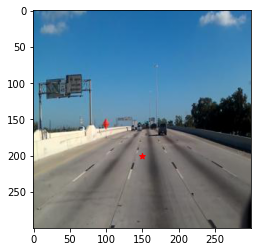

In [207]:
img_name = df.iloc[0]['image']
image = io.imread(path+img_name).astype('double')
image /= 255
point = [150,200]
plt.imshow(image)
plt.scatter(*point, marker = '*', c= 'r')

[ 0 50]
35.35533905932737 35.35533905932738


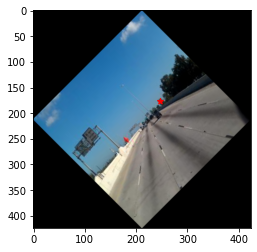

In [211]:
angle = 45
(h, w) = image.shape[:2]
(cX, cY) = (w // 2, h // 2)
c_point = np.array([point[0] - cX, point[1]-cY])
print(c_point)
cos, sin = np.cos(angle*np.pi/180), np.sin(angle*np.pi/180)
rot_matrix = np.array([[cos, -sin], [sin, cos]])
(hn, wn) = img_rot.shape[0:2]
xp, yp = np.dot(c_point, rot_matrix)
print(xp, yp)
point_new = [int(wn//2 + xp), int(hn//2 - yp)]

img_rot = rotate_im(image, angle)
plt.imshow(img_rot)
plt.scatter(*point_new, marker = '*', c= 'r')
plt.show()

In [184]:
np.dot(c_point, rot_matrix)

array([35.35533906, 35.35533906])

In [214]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, coords = sample['image'], sample['coords']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            new_h, new_w = self.output_size * h / w, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        coords = coords * [new_w / w, new_h / h]
        return {'image': img, 'coords': coords}

class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, sample):
        img, coords = sample['image'], sample['coords']
        img_center = np.array(img.shape[:2])[::-1]/2
        img_center = np.hstack((img_center, img_center))
        if random.random() < self.p:
            img =  img[:,::-1,:]
            coords[0] = image.shape[1] - coords[0]
        return {'image': img, 'coords': coords}

class ToTensor(object):
    def __call__(self, sample):
        image, coords = sample['image'], sample['coords']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).float(),
                'coords': torch.from_numpy(coords).float()}

In [225]:
coords = np.array(df.iloc[0][1:]).astype('double')

In [226]:
coords

array([161., 154.])

In [229]:
point = coords
img_rot = rotate_im(image, angle)
(h, w) = image.shape[:2]
(cX, cY) = (w // 2, h // 2)
(nh, nw) = img_rot.shape[:2]
(ncX, ncY) = (nw // 2, nh // 2)
point_ = np.array([point[0] - cX, point[1]-cY])
shift = np.array([ncX, ncY])
cos = np.cos(angle * np.pi /180)
sin = np.sin(angle * np.pi /180)
rot_matrix = np.array([[cos, -sin], [sin, cos]])
point_rot = np.dot(point_, rot_matrix) + shift


In [230]:
point_rot

array([222.60660172, 207.05025253])

In [217]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
train_set = VPDataset(df=train,
                            root_dir=path,
                            transform=transforms.Compose([
                                               Rescale((240, 240)),
                                               RandomHorizontalFlip(),
#                                                RandomRotation(),
                                               ToTensor()]))
test_set = VPDataset(df=test,
                            root_dir=path,
                            transform=transforms.Compose([
                                               Rescale((240, 240)),
                                               ToTensor()]))

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=1)

In [218]:
class Mobilenetv2(nn.Module):
    def __init__(self):
        super(Mobilenetv2, self).__init__()
        self.model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
        self.model.classifier = nn.Sequential(
            nn.Linear(in_features=self.model.classifier[1].in_features, out_features=128),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(inplace = True),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
        )   
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        x = self.model.classifier(x)
        return {'coords': coords}

net = Mobilenetv2()

Downloading: "https://github.com/pytorch/vision/archive/master.zip" to /Users/alisakugusheva/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/alisakugusheva/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

In [221]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = net.to(device).float()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
PATH = "model.pt"

In [ ]:
images = sample['image'].to(device)
        dog_prob = sample['dog_score'].to(device)
        coords = sample['coords'].to(device)
        images /= 255
        coords /= images.shape[2]

In [224]:
n_epochs = 3
# stats = {'epoch': [], 'train_loss': [], 'val_loss': [], 'acc': []}
val_loss_min = np.Inf
total_step = len(train_loader)
for epoch in range(n_epochs):
    train_loss = 0
#     stats['epoch'].append(epoch)
    model.train()
    for i, sample in enumerate(train_loader):
        images = sample['image'].to(device)
        coords = sample['coords'].to(device)
        coords /= images.shape[2]
        optimizer.zero_grad()
        outputs = model(images)

        coords_hat = outputs['coords']
        loss = criterion(coords_hat, coords.squeeze().type(torch.float))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print ("Epoch {}, Train Loss: {:.4f}".format(epoch, i+1, train_loss/len(train_loader)))
    
    model.eval()
    with torch.no_grad():
        
        val_loss = 0
        for i, sample in enumerate(test_loader):
            images = sample['image'].to(device)
            coords = sample['coords'].to(device)
            coords /= images.shape[2]
            outputs = model(images)
            coords_hat = outputs['coords']
            loss = criterion_multioutput(coords_hat, coords.squeeze().type(torch.float))

            val_loss += loss.item()
    print ("Epoch {}, Test Loss: {:.4f}".format(epoch, i+1, train_loss/len(test_loader)))
        
    if val_loss < val_loss_min:
        torch.save(net.state_dict(), PATH)
        val_loss_min = val_loss
        print('Saving model...')

KeyboardInterrupt: 